<a href="https://colab.research.google.com/github/rodrigo0345/Aprof2/blob/main/Task1_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Compose, Lambda, Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Normalize
import torch.optim as optim
import seaborn as sns

# openpyxl é preciso ser instalado para TPUs
!pip install decord openpyxl
import decord
from decord import VideoReader
import os
# from torchinfo import summary
# from livelossplot import PlotLosses

np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 108.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "drive/MyDrive/suturas-filtered/"
labels_path = "drive/MyDrive/OSATS.xlsx"

info_df = pd.read_excel(labels_path)

# Get list of video files in the directory
video_files = [f.replace("output_prewitt_", "").replace(".mp4", "") for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(('.mp4', '.avi', '.mov'))]
video_column = 'VIDEO'

info_df = info_df[info_df[video_column].isin(video_files)]
print(f"Number of videos after filtering: {len(info_df)}")
info_df.head()


Number of videos after filtering: 90


,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
21,ALN135,E-LEARNING,POST,3.5,A,A61V,4,2,3,3,2,3,3,4,24
22,ALN135,E-LEARNING,POST,3.5,B,A61V,4,3,4,3,3,4,3,4,28
23,ALN135,E-LEARNING,POST,3.5,C,A61V,4,3,2,3,3,3,3,3,24
42,BOG917,HMD-BASED,PRE,2.5,A,C16G,3,3,3,2,2,2,2,1,18
43,BOG917,HMD-BASED,PRE,2.5,B,C16G,2,2,3,2,3,3,3,3,21


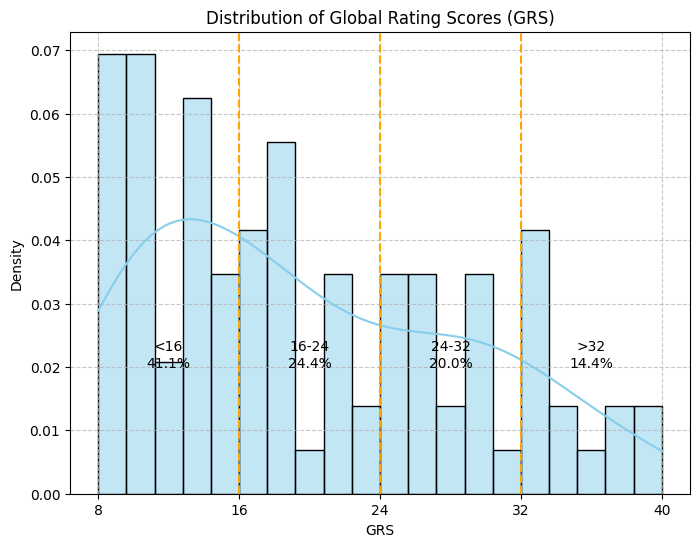

In [ ]:
# Dataset analysis
def plot_grs_distribution(df):
    grs_scores = df['GLOBA_RATING_SCORE'].dropna().values

    if len(grs_scores) == 0:
        print("No GRS scores available to plot.")
        return

    plt.figure(figsize=(8, 6))

    sns.histplot(grs_scores, bins=20, kde=True, stat="density", color="skyblue", alpha=0.5)
    thresholds = [16, 24, 32]
    for threshold in thresholds:
        plt.axvline(threshold, color="orange", linestyle="--", linewidth=1.5)

    total_videos = len(grs_scores)
    bin_percentages = [
        np.sum(grs_scores < 16) / total_videos * 100,  # <16
        np.sum((grs_scores >= 16) & (grs_scores < 24)) / total_videos * 100,  # 16-24
        np.sum((grs_scores >= 24) & (grs_scores < 32)) / total_videos * 100,  # 24-32
        np.sum(grs_scores >= 32) / total_videos * 100  # >=32
    ]

    plt.text(12, 0.02, f"<16\n{bin_percentages[0]:.1f}%", ha="center", color="black")
    plt.text(20, 0.02, f"16-24\n{bin_percentages[1]:.1f}%", ha="center", color="black")
    plt.text(28, 0.02, f"24-32\n{bin_percentages[2]:.1f}%", ha="center", color="black")
    plt.text(36, 0.02, f">32\n{bin_percentages[3]:.1f}%", ha="center", color="black")

    plt.xlabel("GRS")
    plt.ylabel("Density")
    plt.title("Distribution of Global Rating Scores (GRS)")
    plt.xticks(np.arange(8, 41, 8))
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

plot_grs_distribution(info_df)

In [ ]:
# used for Task #1
def get_global_rating_score(video: str):
  try:
    score = info_df[info_df['VIDEO'] == video]['GLOBA_RATING_SCORE'].iloc[0]
    # Get GRS score, nota: acho que até é melhor dividir primeiro por
    if score < 16:
      score = 0
    elif score < 24:
      score = 1
    elif score < 32:
      score = 2
    elif score < 40:
      score = 3
    return score
  except:
    print(f"Video {video} not found")


# used for Task #2
def get_vector_of_ratings(video: str):
  video_data = info_df[info_df['VIDEO'] == video]
  osats_columns = ['OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
                    'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
                    'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY']
  return video_data[osats_columns].iloc[0].values.tolist()

print(get_global_rating_score("A83X"))
print(get_vector_of_ratings("A31H"))

def update_info_df_with_binned_grs(df):
    updated_df = df.copy()
    binned_scores = updated_df['VIDEO'].apply(get_global_rating_score)
    updated_df['GLOBA_RATING_SCORE'] = binned_scores
    if binned_scores.isnull().any():
        print("Warning: Some videos were not found. Corresponding GRS values are None.")
    return updated_df

# change the dataframe to have GRS
info_df = update_info_df_with_binned_grs(info_df)

2
[1, 2, 1, 1, 1, 2, 2, 1]


In [ ]:
print(info_df.index)

Index([ 21,  22,  23,  42,  43,  44, 108, 109, 110, 144, 145, 146, 183, 184,
       185, 258, 259, 260, 267, 268, 269, 318, 319, 320, 342, 343, 344, 378,
       379, 380, 390, 391, 392, 435, 436, 437, 444, 445, 446, 471, 472, 473,
       486, 487, 488, 522, 523, 524, 534, 535, 536, 546, 547, 548, 552, 553,
       554, 567, 568, 569, 582, 583, 584, 639, 640, 641, 657, 658, 659, 693,
       694, 695, 774, 775, 776, 816, 817, 818, 828, 829, 830, 846, 847, 848,
       900, 901, 902, 909, 910, 911],
      dtype='int64')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
         for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

print(device)

cpu


In [ ]:
train_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])
test_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])

In [ ]:
batch_size = 1
segments = 16

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, df_dataset, cfg, dataset_path, segments, segment_frame_pos=0) -> None:
        super().__init__()
        self.df_dataset = df_dataset
        self.dataset_path = dataset_path
        self.cfg = cfg
        self.label = "GLOBA_RATING_SCORE"  # Default to Task 1
        self._segments = segments
        self._segment_frame_pos = segment_frame_pos

    def __len__(self):
        return len(self.df_dataset)

    def set_task_one(self):
        self.label = "GLOBA_RATING_SCORE"

    def set_task_two(self):
        self.label = [
            'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
            'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
            'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY'
        ]

    def __getitem__(self, idx):
        video_path = os.path.join(self.dataset_path, "output_prewitt_" + self.df_dataset.iloc[idx]["VIDEO"] + ".mp4")
        vr = decord.VideoReader(video_path)
        total_frames = len(vr)

        num_frames = self.cfg["num_frames"]
        if total_frames >= num_frames:
            indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        else:
            indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)

        if self._segments is not None:
          # Divide indices into subsets
          subsets = np.array_split(indices, self._segments)
          # Retrieve the first element of each subset
          indices = [subset[self._segment_frame_pos] for subset in subsets]

        frames = vr.get_batch(indices).asnumpy()  # [T, H, W, C], uint8

        # Convert to tensor and normalize to [0, 1]
        frames = torch.from_numpy(frames).float() / 255.0

        # Permute to [T, C, H, W]
        frames = frames.permute(0, 3, 1, 2)

        # Normalize with mean and std
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        normalize = Normalize(mean, std)
        frames = normalize(frames)

        # Short side scale
        side_size = 256
        H, W = vr[0].shape[0], vr[0].shape[1]
        if H < W:
            new_H = side_size
            new_W = int(side_size * W / H)
        else:
            new_W = side_size
            new_H = int(side_size * H / W)

        # Resize using interpolate
        frames = F.interpolate(frames, size=(new_H, new_W), mode='bilinear', align_corners=False)

        # Center crop to 256x256
        crop_size = 256
        start_h = (new_H - crop_size) // 2
        start_w = (new_W - crop_size) // 2
        frames = frames[:, :, start_h:start_h + crop_size, start_w:start_w + crop_size]

        # Permute to [C, T, H, W] to match expected output
        frames = frames.permute(1, 0, 2, 3)

        if isinstance(self.label, str):  # Task 1: Single label
            label = self.df_dataset.iloc[idx][self.label]
            label = torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        else:  # Task 2: Multiple labels
            label = [self.df_dataset.iloc[idx][col] for col in self.label]
            label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        return frames, label

# task = 1 | 2
def prepare_data_loaders(path_train, task=1, segments=None):
    train_df, temp_df = train_test_split(info_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    cfg = {
        "num_frames": 64 # isto não me convence muito
    }
    train_dataset = VideoDataset(train_df, cfg, path_train, segments)
    val_dataset = VideoDataset(val_df, cfg, path_train, segments)
    test_dataset = VideoDataset(test_df, cfg, path_train, segments)

    train_dataset.set_task_one() if task == 1 else train_dataset.set_task_two()
    val_dataset.set_task_one() if task == 1 else val_dataset.set_task_two()
    test_dataset.set_task_one() if task == 1 else test_dataset.set_task_two()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

train_dl, val_dl, test_dl = prepare_data_loaders(path, task = 1, segments=segments)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        print("Starting epoch:", epoch)
        for videos, labels in train_loader:
            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)  # Ensure labels are long

            optimizer.zero_grad()
            outputs = model(videos)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos = videos.to(device)
                labels = labels.to(device, dtype=torch.long)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * videos.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SutureQualityNet(nn.Module):
    def __init__(self, num_classes, num_frames=16, feature_extractor_output_size=1280, rnn_hidden_size=512, rnn_num_layers=2):
        super(SutureQualityNet, self).__init__()
        self.num_frames = num_frames

        # Store feature_extractor_output_size as an instance attribute
        self.feature_extractor_output_size = feature_extractor_output_size

        self.feature_extractor = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        # Remove the original classifier
        self.feature_extractor.classifier = nn.Identity()

        # Temporal Aggregation Layer (LSTM)
        # Input to LSTM is feature_extractor_output_size
        self.rnn = nn.LSTM(self.feature_extractor_output_size, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        # x input shape is expected to be (batch_size, C_video, T_segments, H, W)
        b, c_video, t_segments, h, w = x.size()

        if c_video != 3:
            raise ValueError(f"Input images expected to have 3 channels (RGB), got {c_video} channels.")

        # (b, c_video, t_segments, h, w) -> (b, t_segments, c_video, h, w)
        x = x.permute(0, 2, 1, 3, 4)

        # (b, t_segments, c_video, h, w) -> (b * t_segments, c_video, h, w)
        x = x.reshape(b * t_segments, c_video, h, w)

        # Output shape: (b * t_segments, self.feature_extractor_output_size)
        frame_features = self.feature_extractor(x)

        # Reshape features back to sequence format for RNN
        # (b * t_segments, self.feature_extractor_output_size) -> (b, t_segments, self.feature_extractor_output_size)
        frame_features = frame_features.view(b, t_segments, self.feature_extractor_output_size) # Now this will work

        out_rnn, _ = self.rnn(frame_features)
        out = out_rnn[:, -1, :]
        out = self.fc(out)

        return out

In [ ]:
num_classes = 4
model = SutureQualityNet(num_classes=num_classes, num_frames=segments)
train_model(model, train_dl, val_dl, num_epochs=1)
torch.save(model, "SutureQuality_MobileNetV2.pth")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.8MB/s]


Starting epoch: 0
Epoch 1/1, Train Loss: 1.3676, Train Acc: 0.4444, Val Loss: 1.2537, Val Acc: 0.5385


In [ ]:
def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * videos.size(0)

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_mae = mean_absolute_error(true_labels, predictions)
    test_f1 = f1_score(true_labels, predictions, average='weighted')
    test_accuracy = accuracy_score(true_labels, predictions)

    print(f"Test Loss (CrossEntropy): {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_mae, test_f1, test_accuracy

model = torch.load("SutureQuality_MobileNetV2.pth", weights_only=False)
test_loss, test_mae, test_f1, test_accuracy = evaluate_model(model, test_dl)

Test Loss (CrossEntropy): 1.2739, Test MAE: 1.0000
Test F1 Score (weighted): 0.3333, Test Accuracy: 0.5000
